In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import warnings
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import pickle
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import copy
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
warnings.filterwarnings(action='ignore')
from epftoolbox.evaluation import MAE, sMAPE

C:\Users\csebastian\.conda\envs\BrainEN_v1\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_csv(r"Data/df_alemania_final.csv")

In [3]:
df

,Date,Price,Exogenous 1,Exogenous 2,Exogenous 3
0,2019-01-01 00:00:00,28.32,44216.0,0.0,23266.0
1,2019-01-01 01:00:00,10.07,42397.0,0.0,25111.0
2,2019-01-01 02:00:00,-4.08,40788.0,0.0,26717.0
3,2019-01-01 03:00:00,-9.91,40307.0,0.0,28512.0
4,2019-01-01 04:00:00,-7.41,40479.0,0.0,29911.0
...,...,...,...,...,...
38683,2023-05-31 19:00:00,108.26,57968.0,7000.0,13056.0
38684,2023-05-31 20:00:00,119.60,56582.0,2149.0,13078.0
38685,2023-05-31 21:00:00,103.69,54087.0,276.0,14354.0
38686,2023-05-31 22:00:00,94.28,51883.0,0.0,16051.0


In [4]:
df['Date'] = pd.to_datetime(df.Date)

In [5]:
df.loc[df[df['Exogenous 1'].isna()].index, 'Exogenous 1'] = df.loc[df[df['Exogenous 1'].isna()].index - 24, 'Exogenous 1'].to_numpy()
df.loc[df[df['Exogenous 2'].isna()].index, 'Exogenous 2'] = df.loc[df[df['Exogenous 2'].isna()].index - 24, 'Exogenous 2'].to_numpy()
df.loc[df[df['Exogenous 3'].isna()].index, 'Exogenous 3'] = df.loc[df[df['Exogenous 3'].isna()].index - 24, 'Exogenous 3'].to_numpy()

In [6]:
df.isna().sum()

Date           0
Price          0
Exogenous 1    0
Exogenous 2    0
Exogenous 3    0
dtype: int64

In [7]:
df['Exogenous 2'] = df['Exogenous 2'] + df['Exogenous 3']
df = df.drop(['Exogenous 3'], axis = 1)

In [8]:
df.index = df.Date

In [9]:
df = df.drop('Date', axis = 1)

In [10]:
df_train = df[df.index < dt.datetime(2022, 1, 1)]
df_test = df[df.index >= dt.datetime(2022, 1, 1)]

In [11]:
df_test.columns

Index(['Price', 'Exogenous 1', 'Exogenous 2'], dtype='object')

In [12]:
forecast = pd.DataFrame(index=df_test.index[::24], columns=['h' + str(k) for k in range(24)])
real_values = df_test.loc[:, ['Price']].values.reshape(-1, 24)
real_values = pd.DataFrame(real_values, index=forecast.index, columns=forecast.columns)

In [13]:
forecast_dates = forecast.index

In [14]:
from epftoolbox.models import LEAR

In [15]:
calibration_window = 2*364

In [16]:
model = LEAR(calibration_window=calibration_window)

In [17]:
# For loop over the recalibration dates
for date in forecast_dates:

    # For simulation purposes, we assume that the available data is
    # the data up to current date where the prices of current date are not known
    data_available = pd.concat([df_train, df_test.loc[:date + pd.Timedelta(hours=23), :]], axis=0)

    # We set the real prices for current date to NaN in the dataframe of available data
    data_available.loc[date:date + pd.Timedelta(hours=23), 'Price'] = np.NaN

    # Recalibrating the model with the most up-to-date available data and making a prediction
    # for the next day
    Yp = model.recalibrate_and_forecast_next_day(df=data_available, next_day_date=date, 
                                                 calibration_window=calibration_window)
    # Saving the current prediction
    forecast.loc[date, :] = Yp

    # Computing metrics up-to-current-date
    mae = np.mean(MAE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) 
    smape = np.mean(sMAPE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) * 100

    # Pringint information
    print('{} - sMAPE: {:.2f}%  |  MAE: {:.3f}'.format(str(date)[:10], smape, mae))

2022-01-01 - sMAPE: 103.95%  |  MAE: 50.083
2022-01-02 - sMAPE: 77.28%  |  MAE: 40.726
2022-01-03 - sMAPE: 81.73%  |  MAE: 40.103
2022-01-04 - sMAPE: 66.41%  |  MAE: 36.928
2022-01-05 - sMAPE: 55.98%  |  MAE: 32.423
2022-01-06 - sMAPE: 50.55%  |  MAE: 33.816
2022-01-07 - sMAPE: 48.69%  |  MAE: 37.032
2022-01-08 - sMAPE: 45.03%  |  MAE: 36.241
2022-01-09 - sMAPE: 42.35%  |  MAE: 35.309
2022-01-10 - sMAPE: 39.00%  |  MAE: 34.440
2022-01-11 - sMAPE: 36.14%  |  MAE: 32.914
2022-01-12 - sMAPE: 34.05%  |  MAE: 32.133
2022-01-13 - sMAPE: 32.02%  |  MAE: 30.658
2022-01-14 - sMAPE: 30.34%  |  MAE: 29.694
2022-01-15 - sMAPE: 28.74%  |  MAE: 28.590
2022-01-16 - sMAPE: 28.27%  |  MAE: 28.599
2022-01-17 - sMAPE: 28.82%  |  MAE: 28.893
2022-01-18 - sMAPE: 28.03%  |  MAE: 28.904
2022-01-19 - sMAPE: 27.09%  |  MAE: 28.253
2022-01-20 - sMAPE: 26.20%  |  MAE: 27.420
2022-01-21 - sMAPE: 25.48%  |  MAE: 26.968
2022-01-22 - sMAPE: 24.64%  |  MAE: 26.291
2022-01-23 - sMAPE: 24.02%  |  MAE: 25.925
2022-01-24

2022-07-11 - sMAPE: 24.48%  |  MAE: 31.835
2022-07-12 - sMAPE: 24.49%  |  MAE: 32.115
2022-07-13 - sMAPE: 24.42%  |  MAE: 32.142
2022-07-14 - sMAPE: 24.35%  |  MAE: 32.167
2022-07-15 - sMAPE: 24.29%  |  MAE: 32.201
2022-07-16 - sMAPE: 24.55%  |  MAE: 32.423
2022-07-17 - sMAPE: 24.51%  |  MAE: 32.426
2022-07-18 - sMAPE: 24.46%  |  MAE: 32.548
2022-07-19 - sMAPE: 24.42%  |  MAE: 32.718
2022-07-20 - sMAPE: 24.35%  |  MAE: 32.719
2022-07-21 - sMAPE: 24.27%  |  MAE: 32.699
2022-07-22 - sMAPE: 24.20%  |  MAE: 32.727
2022-07-23 - sMAPE: 24.16%  |  MAE: 32.805
2022-07-24 - sMAPE: 24.16%  |  MAE: 32.852
2022-07-25 - sMAPE: 24.12%  |  MAE: 32.867
2022-07-26 - sMAPE: 24.05%  |  MAE: 32.850
2022-07-27 - sMAPE: 24.03%  |  MAE: 33.036
2022-07-28 - sMAPE: 23.95%  |  MAE: 33.035
2022-07-29 - sMAPE: 23.86%  |  MAE: 32.994
2022-07-30 - sMAPE: 23.78%  |  MAE: 32.963
2022-07-31 - sMAPE: 23.72%  |  MAE: 32.946
2022-08-01 - sMAPE: 23.64%  |  MAE: 32.933
2022-08-02 - sMAPE: 23.56%  |  MAE: 32.870
2022-08-03 

2023-01-18 - sMAPE: 22.83%  |  MAE: 32.825
2023-01-19 - sMAPE: 22.79%  |  MAE: 32.760
2023-01-20 - sMAPE: 22.75%  |  MAE: 32.710
2023-01-21 - sMAPE: 22.74%  |  MAE: 32.687
2023-01-22 - sMAPE: 22.70%  |  MAE: 32.623
2023-01-23 - sMAPE: 22.65%  |  MAE: 32.568
2023-01-24 - sMAPE: 22.61%  |  MAE: 32.508
2023-01-25 - sMAPE: 22.57%  |  MAE: 32.459
2023-01-26 - sMAPE: 22.54%  |  MAE: 32.437
2023-01-27 - sMAPE: 22.50%  |  MAE: 32.386
2023-01-28 - sMAPE: 22.46%  |  MAE: 32.325
2023-01-29 - sMAPE: 22.47%  |  MAE: 32.318
2023-01-30 - sMAPE: 22.50%  |  MAE: 32.275
2023-01-31 - sMAPE: 22.50%  |  MAE: 32.255
2023-02-01 - sMAPE: 22.48%  |  MAE: 32.200
2023-02-02 - sMAPE: 22.45%  |  MAE: 32.159
2023-02-03 - sMAPE: 22.46%  |  MAE: 32.141
2023-02-04 - sMAPE: 22.43%  |  MAE: 32.100
2023-02-05 - sMAPE: 22.40%  |  MAE: 32.050
2023-02-06 - sMAPE: 22.39%  |  MAE: 32.058
2023-02-07 - sMAPE: 22.35%  |  MAE: 32.021
2023-02-08 - sMAPE: 22.32%  |  MAE: 31.967
2023-02-09 - sMAPE: 22.29%  |  MAE: 31.926
2023-02-10 

In [18]:
forecast

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,-9.467438,-15.418655,-17.414867,-18.193071,-15.463481,-11.738911,4.301159,12.779163,18.545402,38.558316,...,50.590948,56.942811,71.732143,77.442003,72.893752,71.405583,56.781193,48.846562,50.112013,41.871744
2022-01-02,82.953733,70.297508,65.593347,55.398428,51.679751,59.603279,67.05743,82.725932,88.687648,100.967489,...,85.33175,87.926601,87.495714,96.135025,95.709476,93.332918,81.550457,65.849292,65.866271,53.658184
2022-01-03,24.405181,21.635908,18.297222,18.086419,18.708341,28.859938,46.688071,64.274731,70.091173,63.842047,...,43.372084,48.23723,57.398599,69.416916,76.928831,76.275704,68.726382,58.271944,56.687418,48.841868
2022-01-04,89.830757,88.325916,85.151496,79.699756,81.650426,98.463737,133.919234,176.637589,221.409963,219.20326,...,157.488568,139.368074,149.90204,159.687243,147.913165,126.119084,106.540535,88.674011,85.674684,72.272779
2022-01-05,94.282528,79.720157,73.297395,65.538412,66.69765,75.303247,86.653527,114.95188,123.831605,120.982493,...,90.045537,91.735779,107.88998,122.102557,129.162886,124.517768,110.314397,94.09868,89.525321,76.687927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-27,91.1182,86.042077,84.413398,81.858677,82.809978,81.98122,79.696924,75.991377,60.890794,45.985375,...,-11.349618,4.349535,26.213768,57.818832,94.87977,130.555873,138.230389,132.827644,126.128921,120.863805
2023-05-28,88.685204,82.233177,79.038244,77.506935,73.585436,68.786831,49.761821,25.588165,-2.380798,-22.75811,...,-79.071339,-77.104146,-44.281703,-17.593508,21.385998,50.107988,67.120025,69.569284,69.738508,58.618409
2023-05-29,61.127159,52.834193,51.112142,48.056432,46.146926,45.16891,47.78512,37.544129,24.962656,4.464047,...,-29.79801,-28.76517,-20.005022,-3.789993,18.650781,51.61841,68.21512,75.806303,72.704979,65.257934


In [19]:
forecast.to_csv("Resultados/alemania_final_2_anos_ventana.csv")

In [20]:
forecast = pd.DataFrame(index=df_test.index[::24], columns=['h' + str(k) for k in range(24)])
real_values = df_test.loc[:, ['Price']].values.reshape(-1, 24)
real_values = pd.DataFrame(real_values, index=forecast.index, columns=forecast.columns)

In [21]:
forecast_dates = forecast.index

In [22]:
calibration_window = 1*364

In [23]:
model = LEAR(calibration_window=calibration_window)

In [24]:
# For loop over the recalibration dates
for date in forecast_dates:

    # For simulation purposes, we assume that the available data is
    # the data up to current date where the prices of current date are not known
    data_available = pd.concat([df_train, df_test.loc[:date + pd.Timedelta(hours=23), :]], axis=0)

    # We set the real prices for current date to NaN in the dataframe of available data
    data_available.loc[date:date + pd.Timedelta(hours=23), 'Price'] = np.NaN

    # Recalibrating the model with the most up-to-date available data and making a prediction
    # for the next day
    Yp = model.recalibrate_and_forecast_next_day(df=data_available, next_day_date=date, 
                                                 calibration_window=calibration_window)
    # Saving the current prediction
    forecast.loc[date, :] = Yp

    # Computing metrics up-to-current-date
    mae = np.mean(MAE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) 
    smape = np.mean(sMAPE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) * 100

    # Pringint information
    print('{} - sMAPE: {:.2f}%  |  MAE: {:.3f}'.format(str(date)[:10], smape, mae))

2022-01-01 - sMAPE: 86.07%  |  MAE: 37.454
2022-01-02 - sMAPE: 66.80%  |  MAE: 33.039
2022-01-03 - sMAPE: 72.18%  |  MAE: 32.730
2022-01-04 - sMAPE: 59.15%  |  MAE: 31.030
2022-01-05 - sMAPE: 50.38%  |  MAE: 27.863
2022-01-06 - sMAPE: 46.68%  |  MAE: 31.251
2022-01-07 - sMAPE: 44.23%  |  MAE: 33.402
2022-01-08 - sMAPE: 41.00%  |  MAE: 32.812
2022-01-09 - sMAPE: 38.98%  |  MAE: 32.704
2022-01-10 - sMAPE: 36.14%  |  MAE: 32.799
2022-01-11 - sMAPE: 33.83%  |  MAE: 32.042
2022-01-12 - sMAPE: 32.21%  |  MAE: 32.056
2022-01-13 - sMAPE: 30.34%  |  MAE: 30.627
2022-01-14 - sMAPE: 28.67%  |  MAE: 29.385
2022-01-15 - sMAPE: 27.53%  |  MAE: 29.049
2022-01-16 - sMAPE: 27.19%  |  MAE: 29.158
2022-01-17 - sMAPE: 27.95%  |  MAE: 29.670
2022-01-18 - sMAPE: 27.08%  |  MAE: 29.603
2022-01-19 - sMAPE: 26.17%  |  MAE: 28.948
2022-01-20 - sMAPE: 25.32%  |  MAE: 28.049
2022-01-21 - sMAPE: 24.55%  |  MAE: 27.448
2022-01-22 - sMAPE: 23.88%  |  MAE: 26.933
2022-01-23 - sMAPE: 23.43%  |  MAE: 26.791
2022-01-24 

2022-07-11 - sMAPE: 23.61%  |  MAE: 30.650
2022-07-12 - sMAPE: 23.58%  |  MAE: 30.813
2022-07-13 - sMAPE: 23.55%  |  MAE: 30.950
2022-07-14 - sMAPE: 23.50%  |  MAE: 31.027
2022-07-15 - sMAPE: 23.42%  |  MAE: 31.008
2022-07-16 - sMAPE: 23.68%  |  MAE: 31.234
2022-07-17 - sMAPE: 23.70%  |  MAE: 31.318
2022-07-18 - sMAPE: 23.67%  |  MAE: 31.463
2022-07-19 - sMAPE: 23.65%  |  MAE: 31.680
2022-07-20 - sMAPE: 23.58%  |  MAE: 31.667
2022-07-21 - sMAPE: 23.50%  |  MAE: 31.631
2022-07-22 - sMAPE: 23.43%  |  MAE: 31.656
2022-07-23 - sMAPE: 23.36%  |  MAE: 31.630
2022-07-24 - sMAPE: 23.38%  |  MAE: 31.717
2022-07-25 - sMAPE: 23.37%  |  MAE: 31.827
2022-07-26 - sMAPE: 23.31%  |  MAE: 31.841
2022-07-27 - sMAPE: 23.32%  |  MAE: 32.106
2022-07-28 - sMAPE: 23.27%  |  MAE: 32.202
2022-07-29 - sMAPE: 23.18%  |  MAE: 32.156
2022-07-30 - sMAPE: 23.12%  |  MAE: 32.172
2022-07-31 - sMAPE: 23.05%  |  MAE: 32.155
2022-08-01 - sMAPE: 23.00%  |  MAE: 32.230
2022-08-02 - sMAPE: 22.93%  |  MAE: 32.190
2022-08-03 

2023-01-18 - sMAPE: 23.90%  |  MAE: 33.683
2023-01-19 - sMAPE: 23.87%  |  MAE: 33.638
2023-01-20 - sMAPE: 23.84%  |  MAE: 33.618
2023-01-21 - sMAPE: 23.88%  |  MAE: 33.627
2023-01-22 - sMAPE: 23.87%  |  MAE: 33.612
2023-01-23 - sMAPE: 23.83%  |  MAE: 33.584
2023-01-24 - sMAPE: 23.80%  |  MAE: 33.569
2023-01-25 - sMAPE: 23.78%  |  MAE: 33.559
2023-01-26 - sMAPE: 23.76%  |  MAE: 33.560
2023-01-27 - sMAPE: 23.73%  |  MAE: 33.532
2023-01-28 - sMAPE: 23.70%  |  MAE: 33.479
2023-01-29 - sMAPE: 23.85%  |  MAE: 33.560
2023-01-30 - sMAPE: 23.88%  |  MAE: 33.517
2023-01-31 - sMAPE: 23.88%  |  MAE: 33.490
2023-02-01 - sMAPE: 23.84%  |  MAE: 33.430
2023-02-02 - sMAPE: 23.83%  |  MAE: 33.431
2023-02-03 - sMAPE: 23.94%  |  MAE: 33.462
2023-02-04 - sMAPE: 23.93%  |  MAE: 33.463
2023-02-05 - sMAPE: 23.89%  |  MAE: 33.402
2023-02-06 - sMAPE: 23.89%  |  MAE: 33.454
2023-02-07 - sMAPE: 23.87%  |  MAE: 33.441
2023-02-08 - sMAPE: 23.85%  |  MAE: 33.406
2023-02-09 - sMAPE: 23.82%  |  MAE: 33.364
2023-02-10 

In [25]:
forecast

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,-14.657108,-13.117628,-2.946731,0.375068,-7.566334,-8.563122,5.039081,12.744581,28.012377,57.892702,...,70.872027,72.493977,84.004305,93.107051,94.26429,85.759542,71.50672,60.710399,67.280022,53.406312
2022-01-02,77.04576,67.773027,61.78849,55.102492,48.427419,54.15718,71.285968,75.168863,79.504977,82.724977,...,64.116827,66.054449,76.06656,92.310836,104.875126,102.033779,96.227396,81.118284,80.367506,71.334872
2022-01-03,13.677468,15.904016,12.28824,10.440043,10.530577,27.047155,59.846814,72.623158,79.38299,69.526691,...,51.386136,54.399774,55.872689,71.884924,82.64029,87.761956,82.179306,71.420288,72.107225,57.873861
2022-01-04,89.809589,83.929915,82.397271,78.545624,77.625325,88.837222,118.345806,151.10625,179.941215,178.807593,...,152.475919,146.300663,155.561024,148.637015,143.511745,124.37459,109.770006,95.031806,89.870737,83.568406
2022-01-05,86.834542,74.727378,69.101217,64.57745,66.803475,73.097375,85.090449,113.919934,125.068558,108.831336,...,87.854296,88.497463,90.529292,113.959864,124.433332,125.070154,117.391179,100.294089,95.027496,81.98055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-27,91.777615,85.350943,84.726131,85.673563,85.246476,85.35528,78.54125,72.287178,55.362802,36.887874,...,-24.271475,3.5613,39.957393,75.621987,100.76906,134.389287,143.737584,139.182817,134.77941,131.305352
2023-05-28,94.82434,87.238574,87.390229,84.0826,80.529198,76.029949,55.444466,30.484092,7.866491,-10.045353,...,-47.722385,-30.33112,2.359929,-5.850452,35.075683,68.105161,92.811753,94.913933,87.41834,81.393879
2023-05-29,67.391361,59.211717,57.593336,55.332034,52.349586,52.574008,47.335175,33.469561,20.938656,6.605531,...,-35.283821,-21.673037,-6.735115,15.650636,39.253039,67.261332,92.922475,93.427533,85.541688,78.370824


In [26]:
forecast.to_csv("Resultados/alemania_final_1_ano_ventana.csv")

In [27]:
forecast = pd.DataFrame(index=df_test.index[::24], columns=['h' + str(k) for k in range(24)])
real_values = df_test.loc[:, ['Price']].values.reshape(-1, 24)
real_values = pd.DataFrame(real_values, index=forecast.index, columns=forecast.columns)

In [28]:
forecast_dates = forecast.index

In [32]:
calibration_window = 182

In [33]:
model = LEAR(calibration_window=calibration_window)

In [34]:
# For loop over the recalibration dates
for date in forecast_dates:

    # For simulation purposes, we assume that the available data is
    # the data up to current date where the prices of current date are not known
    data_available = pd.concat([df_train, df_test.loc[:date + pd.Timedelta(hours=23), :]], axis=0)

    # We set the real prices for current date to NaN in the dataframe of available data
    data_available.loc[date:date + pd.Timedelta(hours=23), 'Price'] = np.NaN

    # Recalibrating the model with the most up-to-date available data and making a prediction
    # for the next day
    Yp = model.recalibrate_and_forecast_next_day(df=data_available, next_day_date=date, 
                                                 calibration_window=calibration_window)
    # Saving the current prediction
    forecast.loc[date, :] = Yp

    # Computing metrics up-to-current-date
    mae = np.mean(MAE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) 
    smape = np.mean(sMAPE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) * 100

    # Pringint information
    print('{} - sMAPE: {:.2f}%  |  MAE: {:.3f}'.format(str(date)[:10], smape, mae))

2022-01-01 - sMAPE: 37.62%  |  MAE: 15.745
2022-01-02 - sMAPE: 29.50%  |  MAE: 12.683
2022-01-03 - sMAPE: 41.88%  |  MAE: 15.458
2022-01-04 - sMAPE: 34.72%  |  MAE: 16.146
2022-01-05 - sMAPE: 30.73%  |  MAE: 15.857
2022-01-06 - sMAPE: 28.00%  |  MAE: 17.442
2022-01-07 - sMAPE: 26.42%  |  MAE: 18.953
2022-01-08 - sMAPE: 24.89%  |  MAE: 19.407
2022-01-09 - sMAPE: 23.40%  |  MAE: 18.599
2022-01-10 - sMAPE: 21.99%  |  MAE: 19.404
2022-01-11 - sMAPE: 20.55%  |  MAE: 19.035
2022-01-12 - sMAPE: 20.12%  |  MAE: 20.472
2022-01-13 - sMAPE: 19.26%  |  MAE: 20.107
2022-01-14 - sMAPE: 18.57%  |  MAE: 20.096
2022-01-15 - sMAPE: 17.97%  |  MAE: 20.168
2022-01-16 - sMAPE: 17.88%  |  MAE: 20.340
2022-01-17 - sMAPE: 19.08%  |  MAE: 21.237
2022-01-18 - sMAPE: 18.47%  |  MAE: 21.059
2022-01-19 - sMAPE: 17.86%  |  MAE: 20.583
2022-01-20 - sMAPE: 17.61%  |  MAE: 20.374
2022-01-21 - sMAPE: 17.28%  |  MAE: 20.238
2022-01-22 - sMAPE: 16.70%  |  MAE: 19.699
2022-01-23 - sMAPE: 16.49%  |  MAE: 19.764
2022-01-24 

2022-07-11 - sMAPE: 20.14%  |  MAE: 25.739
2022-07-12 - sMAPE: 20.15%  |  MAE: 25.969
2022-07-13 - sMAPE: 20.16%  |  MAE: 26.201
2022-07-14 - sMAPE: 20.12%  |  MAE: 26.275
2022-07-15 - sMAPE: 20.06%  |  MAE: 26.309
2022-07-16 - sMAPE: 20.34%  |  MAE: 26.510
2022-07-17 - sMAPE: 20.40%  |  MAE: 26.722
2022-07-18 - sMAPE: 20.39%  |  MAE: 26.906
2022-07-19 - sMAPE: 20.38%  |  MAE: 27.094
2022-07-20 - sMAPE: 20.32%  |  MAE: 27.131
2022-07-21 - sMAPE: 20.27%  |  MAE: 27.159
2022-07-22 - sMAPE: 20.23%  |  MAE: 27.265
2022-07-23 - sMAPE: 20.19%  |  MAE: 27.294
2022-07-24 - sMAPE: 20.23%  |  MAE: 27.397
2022-07-25 - sMAPE: 20.19%  |  MAE: 27.451
2022-07-26 - sMAPE: 20.16%  |  MAE: 27.503
2022-07-27 - sMAPE: 20.19%  |  MAE: 27.824
2022-07-28 - sMAPE: 20.19%  |  MAE: 28.095
2022-07-29 - sMAPE: 20.14%  |  MAE: 28.166
2022-07-30 - sMAPE: 20.10%  |  MAE: 28.196
2022-07-31 - sMAPE: 20.04%  |  MAE: 28.182
2022-08-01 - sMAPE: 19.99%  |  MAE: 28.225
2022-08-02 - sMAPE: 19.93%  |  MAE: 28.196
2022-08-03 

2023-01-18 - sMAPE: 24.49%  |  MAE: 33.044
2023-01-19 - sMAPE: 24.47%  |  MAE: 33.010
2023-01-20 - sMAPE: 24.44%  |  MAE: 32.999
2023-01-21 - sMAPE: 24.47%  |  MAE: 33.013
2023-01-22 - sMAPE: 24.45%  |  MAE: 32.981
2023-01-23 - sMAPE: 24.42%  |  MAE: 32.975
2023-01-24 - sMAPE: 24.40%  |  MAE: 32.985
2023-01-25 - sMAPE: 24.37%  |  MAE: 32.986
2023-01-26 - sMAPE: 24.34%  |  MAE: 32.965
2023-01-27 - sMAPE: 24.31%  |  MAE: 32.939
2023-01-28 - sMAPE: 24.29%  |  MAE: 32.911
2023-01-29 - sMAPE: 24.37%  |  MAE: 32.939
2023-01-30 - sMAPE: 24.39%  |  MAE: 32.899
2023-01-31 - sMAPE: 24.42%  |  MAE: 32.904
2023-02-01 - sMAPE: 24.42%  |  MAE: 32.864
2023-02-02 - sMAPE: 24.38%  |  MAE: 32.813
2023-02-03 - sMAPE: 24.40%  |  MAE: 32.795
2023-02-04 - sMAPE: 24.36%  |  MAE: 32.744
2023-02-05 - sMAPE: 24.32%  |  MAE: 32.692
2023-02-06 - sMAPE: 24.32%  |  MAE: 32.728
2023-02-07 - sMAPE: 24.29%  |  MAE: 32.717
2023-02-08 - sMAPE: 24.28%  |  MAE: 32.697
2023-02-09 - sMAPE: 24.25%  |  MAE: 32.661
2023-02-10 

In [35]:
forecast

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,10.726495,7.922075,16.815368,20.795823,13.878304,17.040304,42.745956,8.367622,37.555174,62.453517,...,106.230115,109.075918,142.866707,185.763914,168.019141,133.209694,103.165486,91.091836,96.436707,78.87909
2022-01-02,63.561517,55.395602,53.13686,37.299889,30.775215,39.456181,44.028879,14.119365,30.476094,46.421984,...,41.657792,37.726928,45.4672,62.053422,80.263549,76.926911,61.756926,45.784892,56.48017,50.698155
2022-01-03,-2.490355,-7.292275,-11.424854,-27.706815,-6.735043,27.689013,80.337825,90.770214,106.105374,90.133038,...,73.67775,81.455635,96.310449,108.973856,94.00115,97.95051,83.971963,75.568994,69.447925,53.331117
2022-01-04,93.20178,92.934812,91.710075,89.718094,95.320288,114.782243,156.004436,191.781982,212.54182,212.092769,...,184.962012,176.981563,182.549719,190.305136,168.984204,148.449385,112.296472,94.102587,85.950029,78.969255
2022-01-05,83.308215,72.114919,64.043865,59.156825,63.054302,75.709086,96.418356,133.367685,147.825372,122.993455,...,91.238401,98.38408,115.851686,151.230382,155.289565,145.47667,129.890669,110.642163,99.170487,84.510673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-27,89.077855,82.034645,81.753433,81.815225,83.314447,87.294725,87.737977,87.016743,79.128191,63.971255,...,2.411788,8.304901,33.372372,64.170892,95.955925,122.650437,136.064563,126.484522,116.462749,112.580893
2023-05-28,90.014897,83.898092,83.544156,82.352872,82.926251,87.289697,87.748347,85.908763,75.362702,56.261701,...,-13.958247,-6.518191,14.519093,45.44162,78.386915,103.944047,118.578338,109.035149,100.924551,94.145622
2023-05-29,66.293757,60.714119,60.251982,59.676871,60.958166,65.833387,70.395026,70.406927,64.182484,47.03229,...,-15.22265,-7.259897,14.713356,40.592715,74.288371,104.878359,118.519767,105.271446,93.880545,84.829576


In [36]:
forecast.to_csv("Resultados/alemania_final_6_meses_ventana.csv")

# Estandarización móvil

In [10]:
df = pd.read_csv("Data/df_alemania_final.csv")
# df['Date'] = pd.to_datetime(df.Date)

In [11]:
df['Date'] = pd.to_datetime(df.Date)
df['Simple Date'] = df.Date.dt.strftime("%Y-%m-%d")
df['Hour'] = df.Date.dt.hour

In [12]:
df.loc[df[df['Exogenous 1'].isna()].index, 'Exogenous 1'] = df.loc[df[df['Exogenous 1'].isna()].index - 24, 'Exogenous 1'].to_numpy()
df.loc[df[df['Exogenous 2'].isna()].index, 'Exogenous 2'] = df.loc[df[df['Exogenous 2'].isna()].index - 24, 'Exogenous 2'].to_numpy()
df.loc[df[df['Exogenous 3'].isna()].index, 'Exogenous 3'] = df.loc[df[df['Exogenous 3'].isna()].index - 24, 'Exogenous 3'].to_numpy()

In [13]:
df.isna().sum()

Date           0
Price          0
Exogenous 1    0
Exogenous 2    0
Exogenous 3    0
Simple Date    0
Hour           0
dtype: int64

In [14]:
df['Exogenous 2'] = df['Exogenous 2'] + df['Exogenous 3']
df = df.drop(['Exogenous 3'], axis = 1)

In [15]:
df

,Date,Price,Exogenous 1,Exogenous 2,Simple Date,Hour
0,2019-01-01 00:00:00,28.32,44216.0,23266.0,2019-01-01,0
1,2019-01-01 01:00:00,10.07,42397.0,25111.0,2019-01-01,1
2,2019-01-01 02:00:00,-4.08,40788.0,26717.0,2019-01-01,2
3,2019-01-01 03:00:00,-9.91,40307.0,28512.0,2019-01-01,3
4,2019-01-01 04:00:00,-7.41,40479.0,29911.0,2019-01-01,4
...,...,...,...,...,...,...
38683,2023-05-31 19:00:00,108.26,57968.0,20056.0,2023-05-31,19
38684,2023-05-31 20:00:00,119.60,56582.0,15227.0,2023-05-31,20
38685,2023-05-31 21:00:00,103.69,54087.0,14630.0,2023-05-31,21
38686,2023-05-31 22:00:00,94.28,51883.0,16051.0,2023-05-31,22


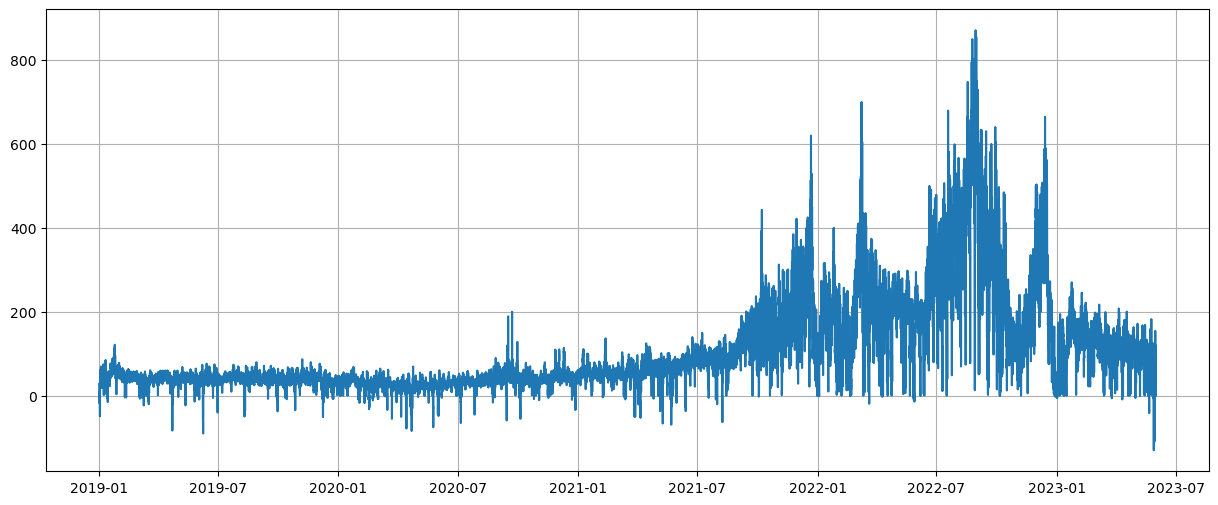

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
ax.plot(df.Date, df.Price)
ax.grid()

Se añaden variables auxiliares

In [17]:
# df['Price_24'] = df.Price.shift(24)
# df['Price_48'] = df.Price.shift(48)
# df['Price_72'] = df.Price.shift(72)
# df['Price_168'] = df.Price.shift(168)

In [18]:
# names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# for i, x in enumerate(names):
#     df[x] = (pd.to_datetime(df['Simple Date']).dt.weekday == i).astype(int)

In [19]:
# for hora in range(24):
#     df['Price_hora_'+str(hora)] = np.nan

# for fecha in df['Simple Date'].unique():
#     df_fecha = df[df['Simple Date'] == fecha]
    
#     for hora in df_fecha.Hour.unique():
#         Price_hora = df_fecha[df_fecha.Hour == hora].Price.values[0]
        
#         df.loc[df_fecha.index, 'Price_hora_'+str(hora)] = Price_hora

In [20]:
# for col in ['Price_hora_'+str(hora) for hora in range(24)]:
#     df[col+"_"+str(24)] = df[col].shift(24)
#     df[col+"_"+str(48)] = df[col].shift(48)
#     df[col+"_"+str(72)] = df[col].shift(72)
#     df[col+"_"+str(168)] = df[col].shift(168)

In [21]:
# for hora in range(24):
#     df['Exogenous 1_hora_'+str(hora)] = np.nan

# for fecha in df['Simple Date'].unique():
#     df_fecha = df[df['Simple Date'] == fecha]
    
#     for hora in df_fecha.Hour.unique():
#         Exogenous_1_hora = df_fecha[df_fecha.Hour == hora]['Exogenous 1'].values[0]
        
#         df.loc[df_fecha.index, 'Exogenous 1_hora_'+str(hora)] = Exogenous_1_hora

In [22]:
# for hora in range(24):
#     df['Exogenous 2_hora_'+str(hora)] = np.nan

# for fecha in df['Simple Date'].unique():
#     df_fecha = df[df['Simple Date'] == fecha]
    
#     for hora in df_fecha.Hour.unique():
#         Exogenous_2_hora = df_fecha[df_fecha.Hour == hora]['Exogenous 2'].values[0]
        
#         df.loc[df_fecha.index, 'Exogenous 2_hora_'+str(hora)] = Exogenous_2_hora

In [23]:
# for col in ['Exogenous 1_hora_'+str(hora) for hora in range(24)]:
#     df[col+"_"+str(24)] = df[col].shift(24)
# #     df[col+"_"+str(48)] = df[col].shift(48)
# #     df[col+"_"+str(72)] = df[col].shift(72)
#     df[col+"_"+str(168)] = df[col].shift(168)
# for col in ['Exogenous 2_hora_'+str(hora) for hora in range(24)]:
#     df[col+"_"+str(24)] = df[col].shift(24)
# #     df[col+"_"+str(48)] = df[col].shift(48)
# #     df[col+"_"+str(72)] = df[col].shift(72)
#     df[col+"_"+str(168)] = df[col].shift(168)

In [24]:
# list(df.columns)

In [28]:
columnas = ['Date',
 'Price',
 'Exogenous 1',
 'Exogenous 2',
 'Simple Date',
 'Hour',
#  'Price_24',
#  'Price_48',
#  'Price_72',
#  'Price_168',
#  'Price_hora_0',
#  'Price_hora_1',
#  'Price_hora_2',
#  'Price_hora_3',
#  'Price_hora_4',
#  'Price_hora_5',
#  'Price_hora_6',
#  'Price_hora_7',
#  'Price_hora_8',
#  'Price_hora_9',
#  'Price_hora_10',
#  'Price_hora_11',
#  'Price_hora_12',
#  'Price_hora_13',
#  'Price_hora_14',
#  'Price_hora_15',
#  'Price_hora_16',
#  'Price_hora_17',
#  'Price_hora_18',
#  'Price_hora_19',
#  'Price_hora_20',
#  'Price_hora_21',
#  'Price_hora_22',
#  'Price_hora_23',
#  'Price_hora_0_24',
#  'Price_hora_0_48',
#  'Price_hora_0_72',
#  'Price_hora_0_168',
#  'Price_hora_1_24',
#  'Price_hora_1_48',
#  'Price_hora_1_72',
#  'Price_hora_1_168',
#  'Price_hora_2_24',
#  'Price_hora_2_48',
#  'Price_hora_2_72',
#  'Price_hora_2_168',
#  'Price_hora_3_24',
#  'Price_hora_3_48',
#  'Price_hora_3_72',
#  'Price_hora_3_168',
#  'Price_hora_4_24',
#  'Price_hora_4_48',
#  'Price_hora_4_72',
#  'Price_hora_4_168',
#  'Price_hora_5_24',
#  'Price_hora_5_48',
#  'Price_hora_5_72',
#  'Price_hora_5_168',
#  'Price_hora_6_24',
#  'Price_hora_6_48',
#  'Price_hora_6_72',
#  'Price_hora_6_168',
#  'Price_hora_7_24',
#  'Price_hora_7_48',
#  'Price_hora_7_72',
#  'Price_hora_7_168',
#  'Price_hora_8_24',
#  'Price_hora_8_48',
#  'Price_hora_8_72',
#  'Price_hora_8_168',
#  'Price_hora_9_24',
#  'Price_hora_9_48',
#  'Price_hora_9_72',
#  'Price_hora_9_168',
#  'Price_hora_10_24',
#  'Price_hora_10_48',
#  'Price_hora_10_72',
#  'Price_hora_10_168',
#  'Price_hora_11_24',
#  'Price_hora_11_48',
#  'Price_hora_11_72',
#  'Price_hora_11_168',
#  'Price_hora_12_24',
#  'Price_hora_12_48',
#  'Price_hora_12_72',
#  'Price_hora_12_168',
#  'Price_hora_13_24',
#  'Price_hora_13_48',
#  'Price_hora_13_72',
#  'Price_hora_13_168',
#  'Price_hora_14_24',
#  'Price_hora_14_48',
#  'Price_hora_14_72',
#  'Price_hora_14_168',
#  'Price_hora_15_24',
#  'Price_hora_15_48',
#  'Price_hora_15_72',
#  'Price_hora_15_168',
#  'Price_hora_16_24',
#  'Price_hora_16_48',
#  'Price_hora_16_72',
#  'Price_hora_16_168',
#  'Price_hora_17_24',
#  'Price_hora_17_48',
#  'Price_hora_17_72',
#  'Price_hora_17_168',
#  'Price_hora_18_24',
#  'Price_hora_18_48',
#  'Price_hora_18_72',
#  'Price_hora_18_168',
#  'Price_hora_19_24',
#  'Price_hora_19_48',
#  'Price_hora_19_72',
#  'Price_hora_19_168',
#  'Price_hora_20_24',
#  'Price_hora_20_48',
#  'Price_hora_20_72',
#  'Price_hora_20_168',
#  'Price_hora_21_24',
#  'Price_hora_21_48',
#  'Price_hora_21_72',
#  'Price_hora_21_168',
#  'Price_hora_22_24',
#  'Price_hora_22_48',
#  'Price_hora_22_72',
#  'Price_hora_22_168',
#  'Price_hora_23_24',
#  'Price_hora_23_48',
#  'Price_hora_23_72',
#  'Price_hora_23_168',
#  'Exogenous 1_hora_0',
#  'Exogenous 1_hora_1',
#  'Exogenous 1_hora_2',
#  'Exogenous 1_hora_3',
#  'Exogenous 1_hora_4',
#  'Exogenous 1_hora_5',
#  'Exogenous 1_hora_6',
#  'Exogenous 1_hora_7',
#  'Exogenous 1_hora_8',
#  'Exogenous 1_hora_9',
#  'Exogenous 1_hora_10',
#  'Exogenous 1_hora_11',
#  'Exogenous 1_hora_12',
#  'Exogenous 1_hora_13',
#  'Exogenous 1_hora_14',
#  'Exogenous 1_hora_15',
#  'Exogenous 1_hora_16',
#  'Exogenous 1_hora_17',
#  'Exogenous 1_hora_18',
#  'Exogenous 1_hora_19',
#  'Exogenous 1_hora_20',
#  'Exogenous 1_hora_21',
#  'Exogenous 1_hora_22',
#  'Exogenous 1_hora_23',
#  'Exogenous 2_hora_0',
#  'Exogenous 2_hora_1',
#  'Exogenous 2_hora_2',
#  'Exogenous 2_hora_3',
#  'Exogenous 2_hora_4',
#  'Exogenous 2_hora_5',
#  'Exogenous 2_hora_6',
#  'Exogenous 2_hora_7',
#  'Exogenous 2_hora_8',
#  'Exogenous 2_hora_9',
#  'Exogenous 2_hora_10',
#  'Exogenous 2_hora_11',
#  'Exogenous 2_hora_12',
#  'Exogenous 2_hora_13',
#  'Exogenous 2_hora_14',
#  'Exogenous 2_hora_15',
#  'Exogenous 2_hora_16',
#  'Exogenous 2_hora_17',
#  'Exogenous 2_hora_18',
#  'Exogenous 2_hora_19',
#  'Exogenous 2_hora_20',
#  'Exogenous 2_hora_21',
#  'Exogenous 2_hora_22',
#  'Exogenous 2_hora_23',
#  'Exogenous 1_hora_0_24',
#  'Exogenous 1_hora_0_168',
#  'Exogenous 1_hora_1_24',
#  'Exogenous 1_hora_1_168',
#  'Exogenous 1_hora_2_24',
#  'Exogenous 1_hora_2_168',
#  'Exogenous 1_hora_3_24',
#  'Exogenous 1_hora_3_168',
#  'Exogenous 1_hora_4_24',
#  'Exogenous 1_hora_4_168',
#  'Exogenous 1_hora_5_24',
#  'Exogenous 1_hora_5_168',
#  'Exogenous 1_hora_6_24',
#  'Exogenous 1_hora_6_168',
#  'Exogenous 1_hora_7_24',
#  'Exogenous 1_hora_7_168',
#  'Exogenous 1_hora_8_24',
#  'Exogenous 1_hora_8_168',
#  'Exogenous 1_hora_9_24',
#  'Exogenous 1_hora_9_168',
#  'Exogenous 1_hora_10_24',
#  'Exogenous 1_hora_10_168',
#  'Exogenous 1_hora_11_24',
#  'Exogenous 1_hora_11_168',
#  'Exogenous 1_hora_12_24',
#  'Exogenous 1_hora_12_168',
#  'Exogenous 1_hora_13_24',
#  'Exogenous 1_hora_13_168',
#  'Exogenous 1_hora_14_24',
#  'Exogenous 1_hora_14_168',
#  'Exogenous 1_hora_15_24',
#  'Exogenous 1_hora_15_168',
#  'Exogenous 1_hora_16_24',
#  'Exogenous 1_hora_16_168',
#  'Exogenous 1_hora_17_24',
#  'Exogenous 1_hora_17_168',
#  'Exogenous 1_hora_18_24',
#  'Exogenous 1_hora_18_168',
#  'Exogenous 1_hora_19_24',
#  'Exogenous 1_hora_19_168',
#  'Exogenous 1_hora_20_24',
#  'Exogenous 1_hora_20_168',
#  'Exogenous 1_hora_21_24',
#  'Exogenous 1_hora_21_168',
#  'Exogenous 1_hora_22_24',
#  'Exogenous 1_hora_22_168',
#  'Exogenous 1_hora_23_24',
#  'Exogenous 1_hora_23_168',
#  'Exogenous 2_hora_0_24',
#  'Exogenous 2_hora_0_168',
#  'Exogenous 2_hora_1_24',
#  'Exogenous 2_hora_1_168',
#  'Exogenous 2_hora_2_24',
#  'Exogenous 2_hora_2_168',
#  'Exogenous 2_hora_3_24',
#  'Exogenous 2_hora_3_168',
#  'Exogenous 2_hora_4_24',
#  'Exogenous 2_hora_4_168',
#  'Exogenous 2_hora_5_24',
#  'Exogenous 2_hora_5_168',
#  'Exogenous 2_hora_6_24',
#  'Exogenous 2_hora_6_168',
#  'Exogenous 2_hora_7_24',
#  'Exogenous 2_hora_7_168',
#  'Exogenous 2_hora_8_24',
#  'Exogenous 2_hora_8_168',
#  'Exogenous 2_hora_9_24',
#  'Exogenous 2_hora_9_168',
#  'Exogenous 2_hora_10_24',
#  'Exogenous 2_hora_10_168',
#  'Exogenous 2_hora_11_24',
#  'Exogenous 2_hora_11_168',
#  'Exogenous 2_hora_12_24',
#  'Exogenous 2_hora_12_168',
#  'Exogenous 2_hora_13_24',
#  'Exogenous 2_hora_13_168',
#  'Exogenous 2_hora_14_24',
#  'Exogenous 2_hora_14_168',
#  'Exogenous 2_hora_15_24',
#  'Exogenous 2_hora_15_168',
#  'Exogenous 2_hora_16_24',
#  'Exogenous 2_hora_16_168',
#  'Exogenous 2_hora_17_24',
#  'Exogenous 2_hora_17_168',
#  'Exogenous 2_hora_18_24',
#  'Exogenous 2_hora_18_168',
#  'Exogenous 2_hora_19_24',
#  'Exogenous 2_hora_19_168',
#  'Exogenous 2_hora_20_24',
#  'Exogenous 2_hora_20_168',
#  'Exogenous 2_hora_21_24',
#  'Exogenous 2_hora_21_168',
#  'Exogenous 2_hora_22_24',
#  'Exogenous 2_hora_22_168',
#  'Exogenous 2_hora_23_24',
#  'Exogenous 2_hora_23_168'
           ]

# columnas_post = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday',
#        'Saturday', 'Sunday']

In [29]:
def standard_movil(df):
    columnas = list(df.columns)
    dict_new_df = {col: [] for col in columnas}
    columnas.remove('Date')
    columnas.remove('Simple Date')
    columnas.remove('Hour')
    dict_new_df['scaler'] = []
    dict_new_df['Price_real'] = []
    for index, row in tqdm(df.iterrows(), total=len(df)):
        if index >= 168*1:
            dict_new_df['Date'].append(row.Date)
            dict_new_df['Simple Date'].append(row['Simple Date'])
            dict_new_df['Hour'].append(row.Hour)
            df_aux = df[(pd.to_datetime(df['Simple Date']) < pd.to_datetime(row['Simple Date'])) & (pd.to_datetime(df['Simple Date']) >= pd.to_datetime(row['Simple Date']) - dt.timedelta(days=7))]
            for col in columnas:
                df_aux_col = df_aux[col].to_numpy().reshape(-1, 1)
                scaler = StandardScaler()
                scaler.fit(df_aux_col)
                if col == 'Price':
                    dict_new_df['scaler'].append(scaler)
                    dict_new_df['Price_real'].append(row[col])
                dict_new_df[col].append(scaler.transform(np.array(row[col]).reshape(1, -1))[0][0])
    return dict_new_df

In [30]:
dict_new_df = standard_movil(df[columnas])

100%|████████████████████████████████████████████████████████████████████████████| 38688/38688 [12:26<00:00, 51.79it/s]


In [31]:
df = df.drop(df.head(168).index)

In [32]:
with open('dict_new_df_alemania_final.pkl', 'wb') as f:
    pickle.dump(dict_new_df, f)

In [59]:
# with open('dict_new_df_alemania.pkl', 'rb') as handle:
#     dict_new_df = pickle.load(handle)

In [60]:
df_nuevo = pd.DataFrame(dict_new_df)

In [33]:
# for col in columnas_post:
#     df_nuevo[col] = df[col].to_numpy()

In [62]:
df_scalers = pd.DataFrame({'Date':dict_new_df['Date'], 'scaler':dict_new_df['scaler']})

In [63]:
df_scalers

,Date,scaler
0,2019-01-08 00:00:00,StandardScaler()
1,2019-01-08 01:00:00,StandardScaler()
2,2019-01-08 02:00:00,StandardScaler()
3,2019-01-08 03:00:00,StandardScaler()
4,2019-01-08 04:00:00,StandardScaler()
...,...,...
38515,2023-05-31 19:00:00,StandardScaler()
38516,2023-05-31 20:00:00,StandardScaler()
38517,2023-05-31 21:00:00,StandardScaler()
38518,2023-05-31 22:00:00,StandardScaler()


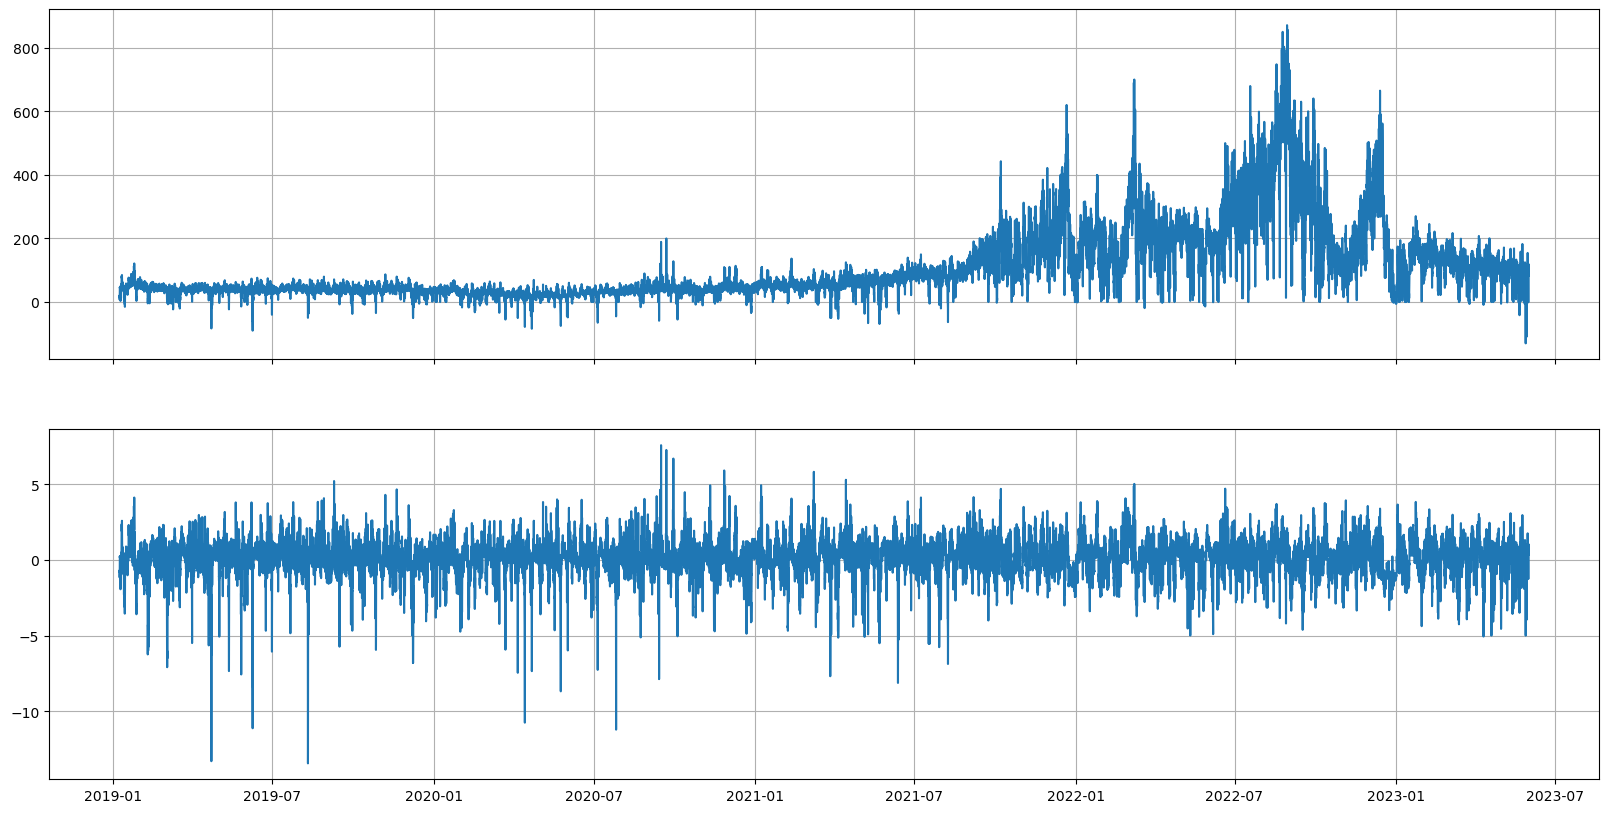

In [64]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10), sharex=True)
ax[0].plot(df_nuevo.Date, df_nuevo.Price_real)
ax[1].plot(df_nuevo.Date, df_nuevo.Price)
ax[0].grid()
ax[1].grid()

In [65]:
df_nuevo

,Date,Price,Exogenous 1,Exogenous 2,Simple Date,Hour,Price_24,Price_48,Price_72,Price_168,...,Exogenous 2_hora_23_168,scaler,Price_real,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,2019-01-08 00:00:00,-0.783812,-0.208629,1.470236,2019-01-08,0,0.292158,0.531294,-0.165772,NaN,...,NaN,StandardScaler(),17.94,0,1,0,0,0,0,0
1,2019-01-08 01:00:00,-0.676750,-0.398239,1.518663,2019-01-08,1,0.360241,0.445979,-0.220297,NaN,...,NaN,StandardScaler(),20.91,0,1,0,0,0,0,0
2,2019-01-08 02:00:00,-1.150058,-0.540122,1.521090,2019-01-08,2,0.355353,0.467889,-0.250929,NaN,...,NaN,StandardScaler(),7.78,0,1,0,0,0,0,0
3,2019-01-08 03:00:00,-0.913945,-0.511330,1.539723,2019-01-08,3,0.294951,0.455938,-0.314645,NaN,...,NaN,StandardScaler(),14.33,0,1,0,0,0,0,0
4,2019-01-08 04:00:00,-0.761462,-0.432607,1.568935,2019-01-08,4,0.293904,0.330123,-0.427065,NaN,...,NaN,StandardScaler(),18.56,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38515,2023-05-31 19:00:00,0.834732,1.036092,-0.143487,2023-05-31,19,1.197151,-0.026829,-0.017029,2.649577,...,-1.569617,StandardScaler(),108.26,0,0,1,0,0,0,0
38516,2023-05-31 20:00:00,1.051629,0.872712,-0.528166,2023-05-31,20,1.766013,0.225402,0.157356,2.972585,...,-1.569617,StandardScaler(),119.60,0,0,1,0,0,0,0
38517,2023-05-31 21:00:00,0.747323,0.578603,-0.575723,2023-05-31,21,1.213838,0.271439,0.104133,2.195180,...,-1.569617,StandardScaler(),103.69,0,0,1,0,0,0,0
38518,2023-05-31 22:00:00,0.567341,0.318797,-0.462526,2023-05-31,22,0.667991,0.154725,0.005045,1.201904,...,-1.569617,StandardScaler(),94.28,0,0,1,0,0,0,0


In [66]:
df_nuevo = df_nuevo.drop(df_nuevo.head(24).index)

# Estandarización móvil + LEAR

In [22]:
with open('dict_new_df_alemania_final.pkl', 'rb') as handle:
    dict_new_df = pickle.load(handle)

In [23]:
df_nuevo = pd.DataFrame(dict_new_df)

In [24]:
df_nuevo['Date'] = pd.to_datetime(df_nuevo.Date)

In [25]:
df_scalers = pd.DataFrame({'Date':dict_new_df['Date'], 'scaler':dict_new_df['scaler']})

In [26]:
df_scalers

,Date,scaler
0,2019-01-08 00:00:00,StandardScaler()
1,2019-01-08 01:00:00,StandardScaler()
2,2019-01-08 02:00:00,StandardScaler()
3,2019-01-08 03:00:00,StandardScaler()
4,2019-01-08 04:00:00,StandardScaler()
...,...,...
38515,2023-05-31 19:00:00,StandardScaler()
38516,2023-05-31 20:00:00,StandardScaler()
38517,2023-05-31 21:00:00,StandardScaler()
38518,2023-05-31 22:00:00,StandardScaler()


In [27]:
df_nuevo = df_nuevo[['Date', 'Price', 'Exogenous 1', 'Exogenous 2']]

In [28]:
df = df_nuevo

In [29]:
df.index = df.Date

In [30]:
df = df.drop(['Date'], axis = 1)

In [31]:
df_train = df[df.index < dt.datetime(2022, 1, 1)]
df_test = df[df.index >= dt.datetime(2022, 1, 1)]

In [32]:
df_test.columns

Index(['Price', 'Exogenous 1', 'Exogenous 2'], dtype='object')

In [33]:
forecast = pd.DataFrame(index=df_test.index[::24], columns=['h' + str(k) for k in range(24)])
# real_values = df_test.loc[:, ['Price']].values.reshape(-1, 24)
# real_values = pd.DataFrame(real_values, index=forecast.index, columns=forecast.columns)

In [34]:
forecast_dates = forecast.index

In [35]:
from epftoolbox.models._lear import LEAR_adaptive_normalization as LEAR

In [36]:
calibration_window = 2*364

In [37]:
model = LEAR(calibration_window=calibration_window)

In [38]:
df_scalers[(df_scalers.Date >= forecast_dates[0]) & (df_scalers.Date <= forecast_dates[0] + pd.Timedelta(hours=23))].scaler.to_numpy()

array([StandardScaler(), StandardScaler(), StandardScaler(),
       StandardScaler(), StandardScaler(), StandardScaler(),
       StandardScaler(), StandardScaler(), StandardScaler(),
       StandardScaler(), StandardScaler(), StandardScaler(),
       StandardScaler(), StandardScaler(), StandardScaler(),
       StandardScaler(), StandardScaler(), StandardScaler(),
       StandardScaler(), StandardScaler(), StandardScaler(),
       StandardScaler(), StandardScaler(), StandardScaler()], dtype=object)

In [39]:
df_original = pd.read_csv(r"Data/df_alemania_final.csv")

In [40]:
df_original['Date'] = pd.to_datetime(df_original.Date)

In [41]:
df_original.loc[df_original[df_original['Exogenous 1'].isna()].index, 'Exogenous 1'] = df_original.loc[df_original[df_original['Exogenous 1'].isna()].index - 24, 'Exogenous 1'].to_numpy()
df_original.loc[df_original[df_original['Exogenous 2'].isna()].index, 'Exogenous 2'] = df_original.loc[df_original[df_original['Exogenous 2'].isna()].index - 24, 'Exogenous 2'].to_numpy()
df_original.loc[df_original[df_original['Exogenous 3'].isna()].index, 'Exogenous 3'] = df_original.loc[df_original[df_original['Exogenous 3'].isna()].index - 24, 'Exogenous 3'].to_numpy()

In [42]:
df_original.isna().sum()

Date           0
Price          0
Exogenous 1    0
Exogenous 2    0
Exogenous 3    0
dtype: int64

In [43]:
df_original['Exogenous 2'] = df_original['Exogenous 2'] + df_original['Exogenous 3']
df_original = df_original.drop(['Exogenous 3'], axis = 1)

In [44]:
df_original.index = df_original.Date

In [45]:
df_original = df_original.drop(['Date'], axis = 1)

In [46]:
real_values = df_original[df_original.index >= dt.datetime(2022, 1, 1)].loc[:, ['Price']].values.reshape(-1, 24)
real_values = pd.DataFrame(real_values, index=forecast.index, columns=forecast.columns)

In [47]:
real_values

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,50.05,41.33,43.22,45.46,37.67,39.70,40.59,43.26,49.66,70.05,...,97.17,101.00,126.60,149.97,146.33,140.28,121.88,102.61,97.46,85.16
2022-01-02,57.08,52.59,48.97,34.94,29.56,33.97,34.52,41.80,48.95,60.01,...,40.01,29.11,32.76,42.97,60.96,60.94,54.12,46.16,46.29,32.93
2022-01-03,0.31,-0.01,-0.07,-1.05,-1.00,0.32,37.55,88.76,122.93,110.17,...,80.99,98.05,123.51,148.49,138.00,117.64,117.71,95.95,105.68,95.26
2022-01-04,103.70,108.27,105.92,103.41,102.71,114.23,156.91,182.64,178.91,190.00,...,179.00,180.93,166.69,189.88,184.94,178.99,156.12,140.92,137.92,97.56
2022-01-05,105.31,97.29,84.50,75.38,79.11,94.79,99.16,101.15,129.56,113.37,...,107.32,119.48,137.28,148.09,139.88,135.75,119.93,98.09,118.71,99.68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-27,89.69,83.53,84.73,86.33,91.25,90.00,82.70,82.99,72.61,55.06,...,-2.39,0.51,2.26,55.08,84.85,100.38,124.93,113.08,100.03,94.71
2023-05-28,87.09,84.00,81.92,77.87,77.86,76.47,72.02,64.84,37.70,0.00,...,-129.96,-98.08,-18.68,-0.06,50.00,72.90,80.01,77.84,73.80,69.50
2023-05-29,59.23,53.90,51.82,48.51,54.52,63.36,67.65,58.71,29.92,0.00,...,-109.45,-80.69,-19.97,-4.98,19.20,72.08,83.75,85.88,80.48,74.26


In [28]:
# For loop over the recalibration dates
for date in forecast_dates:
    
    scalers = df_scalers[(df_scalers.Date >= date) & (df_scalers.Date <= date + pd.Timedelta(hours=23))].scaler.to_numpy()

    # For simulation purposes, we assume that the available data is
    # the data up to current date where the prices of current date are not known
    data_available = pd.concat([df_train, df_test.loc[:date + pd.Timedelta(hours=23), :]], axis=0)

    # We set the real prices for current date to NaN in the dataframe of available data
    data_available.loc[date:date + pd.Timedelta(hours=23), 'Price'] = np.NaN

    # Recalibrating the model with the most up-to-date available data and making a prediction
    # for the next day
    Yp = model.recalibrate_and_forecast_next_day(df=data_available, next_day_date=date, 
                                                 calibration_window=calibration_window, scalers=scalers)
    # Saving the current prediction
    forecast.loc[date, :] = Yp

    # Computing metrics up-to-current-date
    mae = np.mean(MAE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) 
    smape = np.mean(sMAPE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) * 100

    # Pringint information
    print('{} - sMAPE: {:.2f}%  |  MAE: {:.3f}'.format(str(date)[:10], smape, mae))

2022-01-01 - sMAPE: 93.16%  |  MAE: 37.929
2022-01-02 - sMAPE: 68.34%  |  MAE: 25.876
2022-01-03 - sMAPE: 69.88%  |  MAE: 25.490
2022-01-04 - sMAPE: 55.33%  |  MAE: 23.299
2022-01-05 - sMAPE: 47.50%  |  MAE: 21.608
2022-01-06 - sMAPE: 43.44%  |  MAE: 24.882
2022-01-07 - sMAPE: 39.43%  |  MAE: 24.860
2022-01-08 - sMAPE: 36.91%  |  MAE: 25.433
2022-01-09 - sMAPE: 34.91%  |  MAE: 25.287
2022-01-10 - sMAPE: 31.65%  |  MAE: 23.358
2022-01-11 - sMAPE: 29.47%  |  MAE: 23.053
2022-01-12 - sMAPE: 27.87%  |  MAE: 23.314
2022-01-13 - sMAPE: 26.98%  |  MAE: 23.992
2022-01-14 - sMAPE: 25.91%  |  MAE: 23.937
2022-01-15 - sMAPE: 24.64%  |  MAE: 23.344
2022-01-16 - sMAPE: 24.20%  |  MAE: 23.294
2022-01-17 - sMAPE: 24.83%  |  MAE: 23.483
2022-01-18 - sMAPE: 23.85%  |  MAE: 23.050
2022-01-19 - sMAPE: 23.22%  |  MAE: 22.924
2022-01-20 - sMAPE: 22.69%  |  MAE: 22.508
2022-01-21 - sMAPE: 21.98%  |  MAE: 22.036
2022-01-22 - sMAPE: 21.43%  |  MAE: 21.828
2022-01-23 - sMAPE: 20.93%  |  MAE: 21.609
2022-01-24 

2022-07-11 - sMAPE: 21.28%  |  MAE: 26.616
2022-07-12 - sMAPE: 21.21%  |  MAE: 26.598
2022-07-13 - sMAPE: 21.14%  |  MAE: 26.605
2022-07-14 - sMAPE: 21.08%  |  MAE: 26.636
2022-07-15 - sMAPE: 21.03%  |  MAE: 26.647
2022-07-16 - sMAPE: 21.27%  |  MAE: 26.712
2022-07-17 - sMAPE: 21.32%  |  MAE: 26.726
2022-07-18 - sMAPE: 21.26%  |  MAE: 26.796
2022-07-19 - sMAPE: 21.20%  |  MAE: 26.844
2022-07-20 - sMAPE: 21.15%  |  MAE: 26.885
2022-07-21 - sMAPE: 21.07%  |  MAE: 26.852
2022-07-22 - sMAPE: 21.00%  |  MAE: 26.858
2022-07-23 - sMAPE: 20.93%  |  MAE: 26.831
2022-07-24 - sMAPE: 20.96%  |  MAE: 26.927
2022-07-25 - sMAPE: 20.91%  |  MAE: 26.950
2022-07-26 - sMAPE: 20.88%  |  MAE: 27.019
2022-07-27 - sMAPE: 20.87%  |  MAE: 27.232
2022-07-28 - sMAPE: 20.83%  |  MAE: 27.377
2022-07-29 - sMAPE: 20.75%  |  MAE: 27.305
2022-07-30 - sMAPE: 20.68%  |  MAE: 27.294
2022-07-31 - sMAPE: 20.64%  |  MAE: 27.333
2022-08-01 - sMAPE: 20.56%  |  MAE: 27.287
2022-08-02 - sMAPE: 20.54%  |  MAE: 27.410
2022-08-03 

2023-01-18 - sMAPE: 22.12%  |  MAE: 30.462
2023-01-19 - sMAPE: 22.09%  |  MAE: 30.415
2023-01-20 - sMAPE: 22.06%  |  MAE: 30.394
2023-01-21 - sMAPE: 22.05%  |  MAE: 30.371
2023-01-22 - sMAPE: 22.01%  |  MAE: 30.319
2023-01-23 - sMAPE: 21.98%  |  MAE: 30.280
2023-01-24 - sMAPE: 21.93%  |  MAE: 30.220
2023-01-25 - sMAPE: 21.90%  |  MAE: 30.188
2023-01-26 - sMAPE: 21.87%  |  MAE: 30.168
2023-01-27 - sMAPE: 21.83%  |  MAE: 30.108
2023-01-28 - sMAPE: 21.79%  |  MAE: 30.064
2023-01-29 - sMAPE: 22.00%  |  MAE: 30.178
2023-01-30 - sMAPE: 22.05%  |  MAE: 30.149
2023-01-31 - sMAPE: 22.04%  |  MAE: 30.128
2023-02-01 - sMAPE: 22.00%  |  MAE: 30.067
2023-02-02 - sMAPE: 21.97%  |  MAE: 30.020
2023-02-03 - sMAPE: 21.94%  |  MAE: 29.972
2023-02-04 - sMAPE: 21.92%  |  MAE: 29.947
2023-02-05 - sMAPE: 21.88%  |  MAE: 29.895
2023-02-06 - sMAPE: 21.84%  |  MAE: 29.838
2023-02-07 - sMAPE: 21.80%  |  MAE: 29.789
2023-02-08 - sMAPE: 21.77%  |  MAE: 29.752
2023-02-09 - sMAPE: 21.75%  |  MAE: 29.719
2023-02-10 

In [29]:
forecast

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,-9.833047,-13.476483,-12.026471,-14.705988,-12.842186,-11.022382,-34.302272,-27.774149,-10.142076,41.014144,...,60.571314,78.321678,105.246844,139.968008,127.974992,110.892209,83.019889,70.54979,74.873195,60.222192
2022-01-02,61.883524,44.606884,44.314096,34.058054,32.612949,35.083469,41.249145,50.561791,58.740691,74.596194,...,-6.253796,-2.152563,18.083278,57.887507,64.983689,39.05845,33.476082,27.480435,34.062568,10.272368
2022-01-03,8.597315,-0.330559,2.772136,-3.42928,3.018816,20.178694,42.230548,79.746297,94.147805,84.852985,...,39.393345,54.211399,69.262788,107.387406,104.756433,99.182569,86.684885,75.680706,78.842172,62.97807
2022-01-04,80.608479,91.073557,96.632183,101.26725,111.35005,121.541659,147.91023,181.93495,210.574578,218.709028,...,184.940497,177.256064,179.660264,205.284558,178.043145,153.805081,132.670749,106.744821,99.556043,81.20684
2022-01-05,80.605229,72.627621,62.592017,56.610241,53.498971,60.834953,81.154872,119.982656,134.414844,128.300735,...,105.1387,102.1071,114.013933,145.112276,142.440476,133.162775,111.515923,96.781681,98.606668,76.994006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-27,82.906086,73.093662,68.526425,64.988708,63.667213,66.430942,75.668792,76.212686,67.932701,49.439446,...,17.817919,24.652563,38.98731,44.375939,87.526085,118.681032,127.151303,120.920497,113.345733,103.538784
2023-05-28,87.752009,76.691166,71.975013,66.428605,62.877489,62.239185,56.127474,48.145178,41.293107,22.630047,...,2.121386,9.184759,20.918293,21.232188,56.666123,82.877069,95.567831,92.858326,87.586052,74.794108
2023-05-29,61.233648,50.105474,45.491367,39.994123,37.956726,41.16331,48.244341,46.819819,42.557961,24.875199,...,-22.234838,-11.643576,7.37856,16.019256,62.526318,90.331663,102.388566,93.347131,85.326651,70.354372


In [30]:
forecast.to_csv("Resultados/estandarizacion_movil_lear_alemania_final_2_anos_ventana.csv")

In [31]:
forecast = pd.DataFrame(index=df_test.index[::24], columns=['h' + str(k) for k in range(24)])

In [32]:
forecast_dates = forecast.index

In [33]:
calibration_window = 1*364

In [34]:
model = LEAR(calibration_window=calibration_window)

In [35]:
# For loop over the recalibration dates
for date in forecast_dates:
    
    scalers = df_scalers[(df_scalers.Date >= date) & (df_scalers.Date <= date + pd.Timedelta(hours=23))].scaler.to_numpy()

    # For simulation purposes, we assume that the available data is
    # the data up to current date where the prices of current date are not known
    data_available = pd.concat([df_train, df_test.loc[:date + pd.Timedelta(hours=23), :]], axis=0)

    # We set the real prices for current date to NaN in the dataframe of available data
    data_available.loc[date:date + pd.Timedelta(hours=23), 'Price'] = np.NaN

    # Recalibrating the model with the most up-to-date available data and making a prediction
    # for the next day
    Yp = model.recalibrate_and_forecast_next_day(df=data_available, next_day_date=date, 
                                                 calibration_window=calibration_window, scalers=scalers)
    # Saving the current prediction
    forecast.loc[date, :] = Yp

    # Computing metrics up-to-current-date
    mae = np.mean(MAE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) 
    smape = np.mean(sMAPE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) * 100

    # Pringint information
    print('{} - sMAPE: {:.2f}%  |  MAE: {:.3f}'.format(str(date)[:10], smape, mae))

2022-01-01 - sMAPE: 74.97%  |  MAE: 29.186
2022-01-02 - sMAPE: 55.34%  |  MAE: 20.834
2022-01-03 - sMAPE: 61.93%  |  MAE: 23.000
2022-01-04 - sMAPE: 49.93%  |  MAE: 21.962
2022-01-05 - sMAPE: 44.36%  |  MAE: 21.274
2022-01-06 - sMAPE: 41.42%  |  MAE: 25.202
2022-01-07 - sMAPE: 38.19%  |  MAE: 25.679
2022-01-08 - sMAPE: 35.88%  |  MAE: 26.215
2022-01-09 - sMAPE: 33.45%  |  MAE: 25.195
2022-01-10 - sMAPE: 30.55%  |  MAE: 23.886
2022-01-11 - sMAPE: 28.38%  |  MAE: 23.368
2022-01-12 - sMAPE: 26.93%  |  MAE: 23.756
2022-01-13 - sMAPE: 26.00%  |  MAE: 24.234
2022-01-14 - sMAPE: 25.02%  |  MAE: 24.225
2022-01-15 - sMAPE: 23.78%  |  MAE: 23.555
2022-01-16 - sMAPE: 23.51%  |  MAE: 23.686
2022-01-17 - sMAPE: 24.32%  |  MAE: 24.033
2022-01-18 - sMAPE: 23.36%  |  MAE: 23.545
2022-01-19 - sMAPE: 22.67%  |  MAE: 23.215
2022-01-20 - sMAPE: 22.10%  |  MAE: 22.738
2022-01-21 - sMAPE: 21.44%  |  MAE: 22.281
2022-01-22 - sMAPE: 20.87%  |  MAE: 22.007
2022-01-23 - sMAPE: 20.27%  |  MAE: 21.582
2022-01-24 

2022-07-11 - sMAPE: 21.68%  |  MAE: 27.523
2022-07-12 - sMAPE: 21.61%  |  MAE: 27.524
2022-07-13 - sMAPE: 21.54%  |  MAE: 27.527
2022-07-14 - sMAPE: 21.51%  |  MAE: 27.629
2022-07-15 - sMAPE: 21.43%  |  MAE: 27.597
2022-07-16 - sMAPE: 21.69%  |  MAE: 27.685
2022-07-17 - sMAPE: 21.66%  |  MAE: 27.669
2022-07-18 - sMAPE: 21.60%  |  MAE: 27.744
2022-07-19 - sMAPE: 21.54%  |  MAE: 27.791
2022-07-20 - sMAPE: 21.48%  |  MAE: 27.805
2022-07-21 - sMAPE: 21.40%  |  MAE: 27.784
2022-07-22 - sMAPE: 21.32%  |  MAE: 27.756
2022-07-23 - sMAPE: 21.25%  |  MAE: 27.731
2022-07-24 - sMAPE: 21.28%  |  MAE: 27.816
2022-07-25 - sMAPE: 21.22%  |  MAE: 27.799
2022-07-26 - sMAPE: 21.19%  |  MAE: 27.864
2022-07-27 - sMAPE: 21.19%  |  MAE: 28.111
2022-07-28 - sMAPE: 21.15%  |  MAE: 28.262
2022-07-29 - sMAPE: 21.07%  |  MAE: 28.202
2022-07-30 - sMAPE: 21.00%  |  MAE: 28.188
2022-07-31 - sMAPE: 20.96%  |  MAE: 28.242
2022-08-01 - sMAPE: 20.88%  |  MAE: 28.185
2022-08-02 - sMAPE: 20.85%  |  MAE: 28.301
2022-08-03 

2023-01-18 - sMAPE: 22.49%  |  MAE: 31.041
2023-01-19 - sMAPE: 22.46%  |  MAE: 30.998
2023-01-20 - sMAPE: 22.44%  |  MAE: 30.980
2023-01-21 - sMAPE: 22.42%  |  MAE: 30.951
2023-01-22 - sMAPE: 22.38%  |  MAE: 30.902
2023-01-23 - sMAPE: 22.35%  |  MAE: 30.865
2023-01-24 - sMAPE: 22.30%  |  MAE: 30.806
2023-01-25 - sMAPE: 22.26%  |  MAE: 30.761
2023-01-26 - sMAPE: 22.23%  |  MAE: 30.730
2023-01-27 - sMAPE: 22.18%  |  MAE: 30.670
2023-01-28 - sMAPE: 22.15%  |  MAE: 30.623
2023-01-29 - sMAPE: 22.35%  |  MAE: 30.732
2023-01-30 - sMAPE: 22.41%  |  MAE: 30.710
2023-01-31 - sMAPE: 22.41%  |  MAE: 30.692
2023-02-01 - sMAPE: 22.38%  |  MAE: 30.632
2023-02-02 - sMAPE: 22.35%  |  MAE: 30.590
2023-02-03 - sMAPE: 22.33%  |  MAE: 30.549
2023-02-04 - sMAPE: 22.31%  |  MAE: 30.527
2023-02-05 - sMAPE: 22.27%  |  MAE: 30.469
2023-02-06 - sMAPE: 22.22%  |  MAE: 30.416
2023-02-07 - sMAPE: 22.18%  |  MAE: 30.366
2023-02-08 - sMAPE: 22.15%  |  MAE: 30.331
2023-02-09 - sMAPE: 22.13%  |  MAE: 30.296
2023-02-10 

In [36]:
forecast

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,0.158257,7.017597,8.018859,10.124091,11.663112,5.048919,-21.189976,-15.28327,14.868376,28.807808,...,71.626554,87.148511,121.44672,145.817121,146.226244,128.867571,76.188337,69.822945,71.621253,60.554592
2022-01-02,65.121351,57.104632,51.902273,47.545859,47.173212,41.74604,38.687536,53.335966,65.983679,69.962845,...,9.263267,8.722755,16.657028,52.546929,58.097815,48.467341,42.279831,26.163442,34.80396,9.995841
2022-01-03,12.774226,0.484892,-4.469488,-10.170786,-6.120566,13.231698,34.338474,72.439492,85.426984,78.788757,...,47.040888,57.750135,74.66601,102.77031,91.101444,77.56945,81.219167,71.941741,77.918082,54.539087
2022-01-04,83.835166,83.369439,81.78075,80.46076,92.719208,104.53092,137.619767,177.597163,206.410846,212.046899,...,182.463316,192.113346,192.930753,190.419778,169.416856,152.181232,137.527034,108.10914,96.181288,83.356967
2022-01-05,79.698506,62.459761,46.687172,37.389302,39.503504,54.799167,88.660849,128.639393,143.330047,115.39438,...,101.372947,105.469583,111.025565,137.425659,117.029076,129.97424,114.927751,92.890285,94.753587,61.545718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-27,88.993505,80.955281,73.058966,72.870394,69.282014,71.892432,76.816757,74.430597,66.874298,52.472776,...,-9.874104,-0.03203,27.125895,60.073883,89.323412,120.13622,125.374364,119.862668,113.098694,104.26478
2023-05-28,94.293598,80.562435,74.343199,69.189251,65.797869,63.787314,58.13563,46.403069,41.16229,36.308785,...,-26.947753,-18.816404,5.521758,46.749893,78.835096,100.185224,100.721695,95.280497,88.358252,76.47858
2023-05-29,63.49177,50.059674,43.684221,38.729102,38.888681,43.064836,47.380676,46.605452,43.8148,30.336109,...,-36.167782,-26.713984,-1.397993,34.90689,71.795301,96.629335,99.86226,94.145419,84.343333,71.799447


In [37]:
forecast.to_csv("Resultados/estandarizacion_movil_lear_alemania_final_1_ano_ventana.csv")

In [38]:
forecast = pd.DataFrame(index=df_test.index[::24], columns=['h' + str(k) for k in range(24)])

In [39]:
forecast_dates = forecast.index

In [40]:
calibration_window = 182

In [41]:
model = LEAR(calibration_window=calibration_window)

In [42]:
# For loop over the recalibration dates
for date in forecast_dates:
    
    scalers = df_scalers[(df_scalers.Date >= date) & (df_scalers.Date <= date + pd.Timedelta(hours=23))].scaler.to_numpy()

    # For simulation purposes, we assume that the available data is
    # the data up to current date where the prices of current date are not known
    data_available = pd.concat([df_train, df_test.loc[:date + pd.Timedelta(hours=23), :]], axis=0)

    # We set the real prices for current date to NaN in the dataframe of available data
    data_available.loc[date:date + pd.Timedelta(hours=23), 'Price'] = np.NaN

    # Recalibrating the model with the most up-to-date available data and making a prediction
    # for the next day
    Yp = model.recalibrate_and_forecast_next_day(df=data_available, next_day_date=date, 
                                                 calibration_window=calibration_window, scalers=scalers)
    # Saving the current prediction
    forecast.loc[date, :] = Yp

    # Computing metrics up-to-current-date
    mae = np.mean(MAE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) 
    smape = np.mean(sMAPE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) * 100

    # Pringint information
    print('{} - sMAPE: {:.2f}%  |  MAE: {:.3f}'.format(str(date)[:10], smape, mae))

2022-01-01 - sMAPE: 65.21%  |  MAE: 26.241
2022-01-02 - sMAPE: 43.77%  |  MAE: 17.727
2022-01-03 - sMAPE: 56.55%  |  MAE: 22.328
2022-01-04 - sMAPE: 47.27%  |  MAE: 22.952
2022-01-05 - sMAPE: 43.18%  |  MAE: 22.930
2022-01-06 - sMAPE: 41.35%  |  MAE: 27.983
2022-01-07 - sMAPE: 38.28%  |  MAE: 28.454
2022-01-08 - sMAPE: 35.83%  |  MAE: 28.339
2022-01-09 - sMAPE: 33.55%  |  MAE: 27.310
2022-01-10 - sMAPE: 30.99%  |  MAE: 26.657
2022-01-11 - sMAPE: 28.48%  |  MAE: 25.036
2022-01-12 - sMAPE: 26.89%  |  MAE: 24.925
2022-01-13 - sMAPE: 25.70%  |  MAE: 24.746
2022-01-14 - sMAPE: 24.76%  |  MAE: 24.687
2022-01-15 - sMAPE: 23.69%  |  MAE: 24.345
2022-01-16 - sMAPE: 23.35%  |  MAE: 24.413
2022-01-17 - sMAPE: 24.25%  |  MAE: 24.864
2022-01-18 - sMAPE: 23.21%  |  MAE: 24.085
2022-01-19 - sMAPE: 22.55%  |  MAE: 23.802
2022-01-20 - sMAPE: 22.16%  |  MAE: 23.496
2022-01-21 - sMAPE: 21.45%  |  MAE: 22.963
2022-01-22 - sMAPE: 20.78%  |  MAE: 22.447
2022-01-23 - sMAPE: 20.25%  |  MAE: 22.148
2022-01-24 

2022-07-11 - sMAPE: 21.81%  |  MAE: 27.463
2022-07-12 - sMAPE: 21.75%  |  MAE: 27.479
2022-07-13 - sMAPE: 21.69%  |  MAE: 27.513
2022-07-14 - sMAPE: 21.63%  |  MAE: 27.527
2022-07-15 - sMAPE: 21.56%  |  MAE: 27.515
2022-07-16 - sMAPE: 21.82%  |  MAE: 27.616
2022-07-17 - sMAPE: 21.79%  |  MAE: 27.617
2022-07-18 - sMAPE: 21.73%  |  MAE: 27.684
2022-07-19 - sMAPE: 21.67%  |  MAE: 27.745
2022-07-20 - sMAPE: 21.59%  |  MAE: 27.697
2022-07-21 - sMAPE: 21.51%  |  MAE: 27.668
2022-07-22 - sMAPE: 21.43%  |  MAE: 27.651
2022-07-23 - sMAPE: 21.36%  |  MAE: 27.635
2022-07-24 - sMAPE: 21.38%  |  MAE: 27.708
2022-07-25 - sMAPE: 21.31%  |  MAE: 27.673
2022-07-26 - sMAPE: 21.27%  |  MAE: 27.718
2022-07-27 - sMAPE: 21.27%  |  MAE: 27.968
2022-07-28 - sMAPE: 21.24%  |  MAE: 28.134
2022-07-29 - sMAPE: 21.15%  |  MAE: 28.073
2022-07-30 - sMAPE: 21.08%  |  MAE: 28.034
2022-07-31 - sMAPE: 21.04%  |  MAE: 28.107
2022-08-01 - sMAPE: 20.97%  |  MAE: 28.079
2022-08-02 - sMAPE: 20.93%  |  MAE: 28.153
2022-08-03 

2023-01-18 - sMAPE: 23.27%  |  MAE: 31.999
2023-01-19 - sMAPE: 23.25%  |  MAE: 31.958
2023-01-20 - sMAPE: 23.22%  |  MAE: 31.929
2023-01-21 - sMAPE: 23.20%  |  MAE: 31.896
2023-01-22 - sMAPE: 23.17%  |  MAE: 31.860
2023-01-23 - sMAPE: 23.14%  |  MAE: 31.826
2023-01-24 - sMAPE: 23.08%  |  MAE: 31.761
2023-01-25 - sMAPE: 23.04%  |  MAE: 31.707
2023-01-26 - sMAPE: 23.00%  |  MAE: 31.668
2023-01-27 - sMAPE: 22.96%  |  MAE: 31.603
2023-01-28 - sMAPE: 22.91%  |  MAE: 31.549
2023-01-29 - sMAPE: 23.06%  |  MAE: 31.635
2023-01-30 - sMAPE: 23.11%  |  MAE: 31.599
2023-01-31 - sMAPE: 23.11%  |  MAE: 31.580
2023-02-01 - sMAPE: 23.07%  |  MAE: 31.526
2023-02-02 - sMAPE: 23.05%  |  MAE: 31.494
2023-02-03 - sMAPE: 23.03%  |  MAE: 31.461
2023-02-04 - sMAPE: 23.03%  |  MAE: 31.453
2023-02-05 - sMAPE: 22.98%  |  MAE: 31.395
2023-02-06 - sMAPE: 22.94%  |  MAE: 31.340
2023-02-07 - sMAPE: 22.90%  |  MAE: 31.294
2023-02-08 - sMAPE: 22.88%  |  MAE: 31.261
2023-02-09 - sMAPE: 22.85%  |  MAE: 31.229
2023-02-10 

In [43]:
forecast

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,5.304993,1.251799,14.575726,16.161315,12.51947,6.493161,-25.241139,-9.004177,23.341545,44.293226,...,110.934137,117.894463,126.015533,145.479187,130.192908,107.233069,81.750613,73.490773,76.359871,62.408342
2022-01-02,62.7794,50.93759,49.527867,46.02584,36.993771,38.357829,34.985834,40.682154,48.486174,79.293027,...,28.414885,32.548967,38.930085,56.213469,62.18403,44.20277,37.178828,25.031642,29.472377,9.655596
2022-01-03,8.134696,-1.815304,-6.495525,-10.8068,-8.819551,10.535187,36.932167,91.449281,96.270801,70.78649,...,38.691985,41.626014,55.426485,76.477685,94.671864,86.886665,63.504104,63.377822,67.197064,48.131618
2022-01-04,77.628117,75.985751,73.429633,75.480835,85.481187,101.625599,149.443911,202.031678,231.425209,205.75682,...,148.857131,147.985633,153.485692,173.046634,158.94962,144.403924,115.716199,104.327658,81.781048,71.923693
2022-01-05,71.743983,57.124888,44.333033,35.332496,41.130558,59.780413,93.427474,136.203697,129.511459,119.790842,...,76.210597,77.690607,89.285888,120.100597,136.002833,126.146162,108.927008,98.284648,90.929443,66.711651
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-27,85.752344,80.839057,78.74678,78.472859,78.027277,81.732632,83.286267,81.276152,72.950939,49.143017,...,-19.29251,-7.003974,27.141769,61.324218,93.892411,123.317958,121.521711,115.631326,106.704496,97.03759
2023-05-28,95.191372,83.455367,80.211467,76.112236,73.805602,73.212992,66.371554,62.010678,53.560373,40.041136,...,-34.44297,-23.647834,10.869039,58.501616,85.823486,101.715941,98.424595,95.158824,89.36796,80.193065
2023-05-29,65.387214,56.675126,51.477263,48.636912,49.419624,53.088258,58.112068,58.032856,51.127823,31.654735,...,-45.949526,-29.407732,-1.93759,40.319256,77.929993,96.238138,103.566701,91.467392,76.174338,62.876366


In [44]:
forecast.to_csv("Resultados/estandarizacion_movil_lear_alemania_final_6_meses_ventana.csv")

In [48]:
forecast = pd.DataFrame(index=df_test.index[::24], columns=['h' + str(k) for k in range(24)])

In [49]:
forecast_dates = forecast.index

In [50]:
calibration_window = None

In [51]:
model = LEAR(calibration_window=calibration_window)

In [52]:
# For loop over the recalibration dates
for date in forecast_dates:
    
    scalers = df_scalers[(df_scalers.Date >= date) & (df_scalers.Date <= date + pd.Timedelta(hours=23))].scaler.to_numpy()

    # For simulation purposes, we assume that the available data is
    # the data up to current date where the prices of current date are not known
    data_available = pd.concat([df_train, df_test.loc[:date + pd.Timedelta(hours=23), :]], axis=0)

    # We set the real prices for current date to NaN in the dataframe of available data
    data_available.loc[date:date + pd.Timedelta(hours=23), 'Price'] = np.NaN

    # Recalibrating the model with the most up-to-date available data and making a prediction
    # for the next day
    Yp = model.recalibrate_and_forecast_next_day(df=data_available, next_day_date=date, 
                                                 calibration_window=calibration_window, scalers=scalers)
    # Saving the current prediction
    forecast.loc[date, :] = Yp

    # Computing metrics up-to-current-date
    mae = np.mean(MAE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) 
    smape = np.mean(sMAPE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) * 100

    # Pringint information
    print('{} - sMAPE: {:.2f}%  |  MAE: {:.3f}'.format(str(date)[:10], smape, mae))

2022-01-01 - sMAPE: 92.35%  |  MAE: 37.494
2022-01-02 - sMAPE: 71.55%  |  MAE: 26.797
2022-01-03 - sMAPE: 71.53%  |  MAE: 25.880
2022-01-04 - sMAPE: 56.70%  |  MAE: 23.601
2022-01-05 - sMAPE: 49.60%  |  MAE: 22.334
2022-01-06 - sMAPE: 45.30%  |  MAE: 25.558
2022-01-07 - sMAPE: 41.59%  |  MAE: 25.900
2022-01-08 - sMAPE: 39.20%  |  MAE: 26.972
2022-01-09 - sMAPE: 37.61%  |  MAE: 27.330
2022-01-10 - sMAPE: 34.22%  |  MAE: 25.573
2022-01-11 - sMAPE: 31.61%  |  MAE: 24.461
2022-01-12 - sMAPE: 29.69%  |  MAE: 24.211
2022-01-13 - sMAPE: 28.60%  |  MAE: 24.629
2022-01-14 - sMAPE: 27.44%  |  MAE: 24.631
2022-01-15 - sMAPE: 26.07%  |  MAE: 23.991
2022-01-16 - sMAPE: 25.68%  |  MAE: 24.081
2022-01-17 - sMAPE: 26.09%  |  MAE: 24.087
2022-01-18 - sMAPE: 25.06%  |  MAE: 23.648
2022-01-19 - sMAPE: 24.35%  |  MAE: 23.448
2022-01-20 - sMAPE: 23.73%  |  MAE: 23.018
2022-01-21 - sMAPE: 23.07%  |  MAE: 22.726
2022-01-22 - sMAPE: 22.67%  |  MAE: 22.775
2022-01-23 - sMAPE: 22.31%  |  MAE: 22.832
2022-01-24 

2022-07-11 - sMAPE: 21.48%  |  MAE: 26.588
2022-07-12 - sMAPE: 21.42%  |  MAE: 26.613
2022-07-13 - sMAPE: 21.37%  |  MAE: 26.655
2022-07-14 - sMAPE: 21.31%  |  MAE: 26.702
2022-07-15 - sMAPE: 21.24%  |  MAE: 26.688
2022-07-16 - sMAPE: 21.49%  |  MAE: 26.742
2022-07-17 - sMAPE: 21.53%  |  MAE: 26.760
2022-07-18 - sMAPE: 21.47%  |  MAE: 26.829
2022-07-19 - sMAPE: 21.41%  |  MAE: 26.872
2022-07-20 - sMAPE: 21.36%  |  MAE: 26.903
2022-07-21 - sMAPE: 21.28%  |  MAE: 26.873
2022-07-22 - sMAPE: 21.20%  |  MAE: 26.865
2022-07-23 - sMAPE: 21.13%  |  MAE: 26.832
2022-07-24 - sMAPE: 21.15%  |  MAE: 26.907
2022-07-25 - sMAPE: 21.10%  |  MAE: 26.949
2022-07-26 - sMAPE: 21.07%  |  MAE: 27.025
2022-07-27 - sMAPE: 21.06%  |  MAE: 27.222
2022-07-28 - sMAPE: 21.03%  |  MAE: 27.404
2022-07-29 - sMAPE: 20.94%  |  MAE: 27.338
2022-07-30 - sMAPE: 20.88%  |  MAE: 27.348
2022-07-31 - sMAPE: 20.83%  |  MAE: 27.354
2022-08-01 - sMAPE: 20.75%  |  MAE: 27.315
2022-08-02 - sMAPE: 20.72%  |  MAE: 27.414
2022-08-03 

2023-01-18 - sMAPE: 22.10%  |  MAE: 30.670
2023-01-19 - sMAPE: 22.06%  |  MAE: 30.622
2023-01-20 - sMAPE: 22.03%  |  MAE: 30.596
2023-01-21 - sMAPE: 22.03%  |  MAE: 30.578
2023-01-22 - sMAPE: 22.01%  |  MAE: 30.547
2023-01-23 - sMAPE: 21.97%  |  MAE: 30.513
2023-01-24 - sMAPE: 21.92%  |  MAE: 30.450
2023-01-25 - sMAPE: 21.89%  |  MAE: 30.412
2023-01-26 - sMAPE: 21.86%  |  MAE: 30.391
2023-01-27 - sMAPE: 21.81%  |  MAE: 30.330
2023-01-28 - sMAPE: 21.78%  |  MAE: 30.286
2023-01-29 - sMAPE: 21.98%  |  MAE: 30.396
2023-01-30 - sMAPE: 22.05%  |  MAE: 30.376
2023-01-31 - sMAPE: 22.05%  |  MAE: 30.357
2023-02-01 - sMAPE: 22.02%  |  MAE: 30.305
2023-02-02 - sMAPE: 21.98%  |  MAE: 30.253
2023-02-03 - sMAPE: 21.96%  |  MAE: 30.212
2023-02-04 - sMAPE: 21.95%  |  MAE: 30.190
2023-02-05 - sMAPE: 21.92%  |  MAE: 30.151
2023-02-06 - sMAPE: 21.87%  |  MAE: 30.090
2023-02-07 - sMAPE: 21.84%  |  MAE: 30.047
2023-02-08 - sMAPE: 21.80%  |  MAE: 30.005
2023-02-09 - sMAPE: 21.78%  |  MAE: 29.973
2023-02-10 

In [53]:
forecast

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,-6.787042,-12.938662,-16.039861,-15.783248,-12.996233,-10.351761,-32.910597,-23.65724,5.194137,38.782542,...,58.186988,75.02495,103.632928,139.604447,131.203372,109.067474,86.030682,69.65715,69.958509,56.007345
2022-01-02,54.114505,40.810378,32.517738,26.820009,20.573496,21.681747,30.926239,49.830739,65.550301,69.501657,...,-17.025116,-3.904302,19.167729,54.352312,58.80665,38.851108,31.498986,22.300536,31.878619,10.274228
2022-01-03,6.513165,-3.304716,-12.159513,-15.479193,-9.998705,11.781815,40.20486,78.227104,82.644785,76.077003,...,49.831751,62.901571,77.650544,110.458294,109.814478,105.599925,88.416833,73.887331,79.885367,64.91795
2022-01-04,77.323947,81.01553,85.221911,96.737433,106.245257,116.56994,148.912128,185.538317,206.008341,212.809613,...,188.755868,185.917684,182.259902,203.663157,178.258755,155.518105,135.26355,107.852135,99.17028,83.845657
2022-01-05,75.384468,60.906542,47.226947,40.106732,38.195288,49.445172,77.319216,115.474624,127.482864,115.893149,...,96.479775,98.660049,107.544554,140.086871,133.001864,134.943621,115.651404,96.812905,97.839391,75.677935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-27,85.072507,78.759489,75.261558,74.076924,71.999142,70.39582,71.543342,69.330857,64.869006,47.270227,...,-0.282214,4.1808,19.294578,47.509885,84.333273,113.884404,124.286256,115.627089,109.483306,100.673769
2023-05-28,88.598234,78.506621,75.002745,71.615359,67.873484,62.093919,54.469914,43.249774,37.480358,20.623041,...,-31.376163,-28.650346,-11.563377,16.619885,51.629552,78.813393,95.407628,88.384203,84.471564,70.973996
2023-05-29,60.607369,48.799063,45.848341,43.522678,41.682696,45.575756,50.19672,46.268218,43.824466,24.616907,...,-40.489455,-31.941011,-13.890913,8.890676,54.936416,89.643522,103.021406,92.255606,84.237504,67.582797


In [54]:
forecast.to_csv("Resultados/estandarizacion_movil_lear_alemania_final_sin_ventana.csv")